In [2]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import ElectraForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

device = torch.device("cuda:0")

In [3]:
from transformers import AutoTokenizer
MODEL_NAME= "monologg/koelectra-base-v3-hate-speech"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='monologg/koelectra-base-v3-hate-speech', vocab_size=35000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

# Load Koco Dataset

In [5]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_hate_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_hate_test.txt", sep="\t")
koco_train_df.head(5)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


In [6]:
tokenized_train_sentences = tokenizer(
                            list(koco_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [8]:
train_label = koco_train_df["hate"].values
test_label =  koco_test_df["hate"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

# 모델 튜닝

In [12]:
from coral_pytorch.layers import CoralLayer
from coral_pytorch.losses import CoralLoss, corn_loss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label
from typing import Optional, Union, Tuple
from transformers.activations import get_activation
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

In [13]:
class ElectraClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        classifier_dropout = 0.2
        self.dropout = nn.Dropout(classifier_dropout)
        #self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels-1)
        #self.coral_layer = CoralLayer(config.hidden_size, config.num_labels)
    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = get_activation("gelu")(x)  # although BERT uses tanh here, it seems Electra authors used gelu here
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [14]:
from transformers import ElectraPreTrainedModel, ElectraModel
class ElectraForSequenceClassification(ElectraPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.electra = ElectraModel(config)
        self.classifier = ElectraClassificationHead(config)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        discriminator_hidden_states = self.electra(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = discriminator_hidden_states[0]
        logits = self.classifier(sequence_output) #coral layer
        probas = torch.sigmoid(logits)
        probas = torch.cumprod(probas, dim=1)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
            elif self.config.problem_type == 'CORAL':
                # iw = torch.tensor([0.3, 0.7]).to(device)
                # loss_fct = CoralLoss()
                # levels = levels_from_labelbatch(labels.view(-1) , num_classes=3).to(device)
                # loss = loss_fct(logits, levels)
                loss = corn_loss(logits, labels, self.config.num_labels)

        if not return_dict:
            output = (logits,) + discriminator_hidden_states[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=probas,
            hidden_states=discriminator_hidden_states.hidden_states,
            attentions=discriminator_hidden_states.attentions,
        )


In [15]:
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, problem_type='CORAL')
model.to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-hate-speech were not used when initializing ElectraForSequenceClassification: ['classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-hate-speech and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [16]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [17]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from coral_pytorch.dataset import corn_label_from_logits
def compute_metrics(pred):
    labels = pred.label_ids
    predicts =  pred.predictions
    preds = corn_label_from_logits(torch.tensor(predicts))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
from transformers import Trainer
#model_path = 'C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/pytorch_model.bin'
#model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [21]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.489000
1000,0.480400
1500,0.482200
2000,0.469100
2500,0.368900
3000,0.381300
3500,0.413700
4000,0.371200
4500,0.299600
5000,0.320800


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_CORN_outputs\output\checkpoint-19000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_out

Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-5500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_CORN_outputs\output\checkpoint-4500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBER

Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_CORN_outputs\output\checkpoint-9500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-11000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-11000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_CORN_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-16000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-16000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/checkpoint-16000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_CORN_outputs\output\checkpoint-15000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

TrainOutput(global_step=19740, training_loss=0.17892311194264296, metrics={'train_runtime': 1449.6484, 'train_samples_per_second': 54.468, 'train_steps_per_second': 13.617, 'total_flos': 2600063449067520.0, 'train_loss': 0.17892311194264296, 'epoch': 10.0})

In [30]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'eval_loss': 1.8350980281829834,
 'eval_accuracy': 0.6369426751592356,
 'eval_f1': 0.6340795510171556,
 'eval_precision': 0.6550325275375176,
 'eval_recall': 0.6368203732616301,
 'eval_runtime': 0.8039,
 'eval_samples_per_second': 585.903,
 'eval_steps_per_second': 18.659,
 'epoch': 10.0}

In [23]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_CORN_outputs/output/pytorch_model.bin


In [29]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [25]:
def corn_label_from_logits(logits):
    #probas = torch.cumprod(logits, dim=1)
    #probas = logits
    probas = logits
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    return predicted_labels

              precision    recall  f1-score   support

           0       0.63      0.86      0.73       160
           1       0.58      0.51      0.54       189
           2       0.75      0.54      0.63       122

    accuracy                           0.64       471
   macro avg       0.66      0.64      0.63       471
weighted avg       0.64      0.64      0.63       471



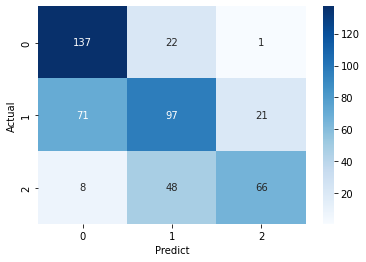

In [26]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = corn_label_from_logits(torch.tensor(predictions.predictions))
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [27]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [28]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3822)
tensor(0.4204)


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [166]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [170]:
predicts_threshold = custom_proba_to_label(predictions.predictions.tolist(), 0.3, 0.7)

              precision    recall  f1-score   support

           0       0.65      0.89      0.75       160
           1       0.59      0.57      0.58       189
           2       0.83      0.49      0.62       122

    accuracy                           0.66       471
   macro avg       0.69      0.65      0.65       471
weighted avg       0.67      0.66      0.65       471



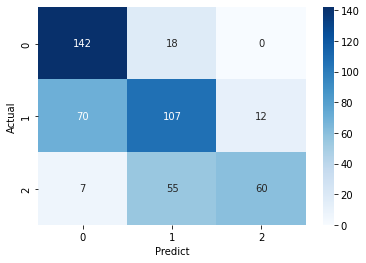

In [171]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predicts_threshold
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [172]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3588)
tensor(0.3885)


In [173]:
predictions

PredictionOutput(predictions=array([[5.69937765e-05, 1.82821022e-05],
       [6.44961536e-01, 3.68165821e-01],
       [6.45221770e-01, 3.68430197e-01],
       [6.44225836e-01, 3.67419124e-01],
       [6.37250245e-01, 3.60404462e-01],
       [9.99988914e-01, 9.99965549e-01],
       [5.50662153e-05, 1.76637677e-05],
       [5.47278214e-05, 1.75552159e-05],
       [5.36926891e-05, 1.72231612e-05],
       [5.35714753e-05, 1.71842767e-05],
       [5.88091862e-05, 1.88644590e-05],
       [3.39006633e-02, 1.11303125e-02],
       [5.58009451e-05, 1.78994578e-05],
       [6.44258678e-01, 3.67452353e-01],
       [6.42345846e-01, 3.65516961e-01],
       [6.44089997e-01, 3.67281348e-01],
       [6.43820822e-01, 3.67008597e-01],
       [9.99988914e-01, 9.99965549e-01],
       [6.43325984e-01, 3.66507530e-01],
       [4.63045895e-01, 2.16675729e-01],
       [5.58557804e-05, 1.79170493e-05],
       [6.56940877e-01, 3.80513966e-01],
       [6.38715744e-01, 3.61868411e-01],
       [6.77559257e-01, 4.02